In [1]:
# Package Setup
import Pkg;
# Pkg.update()

# Julia Packages
using Distributions
using LinearAlgebra
using Statistics
using PGFPlots

# Satellite Dynamics Packages
using SatelliteDynamics

# Load SatelliteTasking - Reclone to keep version current
Pkg.clone("..") # For some reason this doens't work with Pkg.add + PackageSpec. Why?
using SatelliteTasking
using SatelliteTasking.SatellitePlanning
using SatelliteTasking.Analysis

# Temporary for now
Pkg.add("JuMP")
Pkg.add("Gurobi")
using JuMP
using Gurobi

┌ Warning: Pkg.clone is only kept for legacy CI script reasons, please use `add`
└ @ Pkg.API /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Pkg/src/API.jl:386


 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [2]:
# Configure simulation
epc0 = Epoch(2019, 1, 1, 0, 0, 0, tsys=:UTC) # Start of time span
epcf = Epoch(2019, 1, 2, 0, 0, 0, tsys=:UTC) # End of simulation time span

# Set Simulation Time Step
timestep = 1
dtmax    = 5

# Define Satellite Orbit
oe   = [R_EARTH + 500e3, 0, 90.0, 0, 0, 0]
eci0 = sOSCtoCART(oe, use_degrees=true)

# Numer of perturbed orbits to simulate
num_orbits = 110

# Set Perturbation Values 
pos_error = 2500 # Position knowledge error [m]
vel_error = 2.5  # Velocity knowledge error [m/s]
orb_mean  = zeros(Float64, 6)
orb_sdev  = vcat((pos_error/sqrt(3)*ones(Float64, 3))..., (vel_error/sqrt(3)*ones(Float64, 3))...)

# Simulate true and perturbed orbits
@time true_orbit, perturbed_orbits, eci_errors = simulate_orbits(num_orbits, epc0, epcf, eci0, orb_mean, orb_sdev, timestep=timestep, dtmax=dtmax);

Simulating perturbed orbit 1
Simulating perturbed orbit 2
Simulating perturbed orbit 3
Simulating perturbed orbit 4
Simulating perturbed orbit 5
Simulating perturbed orbit 6
Simulating perturbed orbit 7
Simulating perturbed orbit 8
Simulating perturbed orbit 9
Simulating perturbed orbit 10
Simulating perturbed orbit 11
Simulating perturbed orbit 12
Simulating perturbed orbit 13
Simulating perturbed orbit 14
Simulating perturbed orbit 15
Simulating perturbed orbit 16
Simulating perturbed orbit 17
Simulating perturbed orbit 18
Simulating perturbed orbit 19
Simulating perturbed orbit 20
Simulating perturbed orbit 21
Simulating perturbed orbit 22
Simulating perturbed orbit 23
Simulating perturbed orbit 24
Simulating perturbed orbit 25
Simulating perturbed orbit 26
Simulating perturbed orbit 27
Simulating perturbed orbit 28
Simulating perturbed orbit 29
Simulating perturbed orbit 30
Simulating perturbed orbit 31
Simulating perturbed orbit 32
Simulating perturbed orbit 33
Simulating perturbe

In [3]:
# Compute True and perturbed collects

# Load test images
# @time images = load_images("../data/landsat_test_150.json", collect_duration=5.0);
# @time images = load_images("../data/landsat_test_300.json", collect_duration=5.0);
# @time images = load_images("../data/landsat_test_600.json", collect_duration=5.0);
@time images = load_images("../data/landsat_test_1200.json", collect_duration=5.0);
num_images = length(images)

# Compute true and perturbed opportunities
@time true_opportunities, perturbed_opportunities, mean_diff, sdev_diff, missing_opportunities = compute_perturbed_opportunities(true_orbit, perturbed_orbits, images, epc_step=3600);

# 
@time collects = split_opportunities(true_opportunities, 10);

# Compute feasible collects
image_collects = group_image_collects(collects) # Group collects by image
num_feasible   = 0
for img in keys(image_collects)
    if length(image_collects[img]) > 0
        num_feasible += 1
    end
end
pct_feasible = num_feasible/num_images*100

println("$num_feasible out of $num_images images have collection opportunities.")

  0.412853 seconds (722.47 k allocations: 38.660 MiB, 7.00% gc time)
Computing opportunities for perturbed orbit: 1
Computing opportunities for perturbed orbit: 2
Computing opportunities for perturbed orbit: 3
Computing opportunities for perturbed orbit: 4
Computing opportunities for perturbed orbit: 5
Computing opportunities for perturbed orbit: 6
Computing opportunities for perturbed orbit: 7
Computing opportunities for perturbed orbit: 8
Computing opportunities for perturbed orbit: 9
Computing opportunities for perturbed orbit: 10
Computing opportunities for perturbed orbit: 11
Computing opportunities for perturbed orbit: 12
Computing opportunities for perturbed orbit: 13
Computing opportunities for perturbed orbit: 14
Computing opportunities for perturbed orbit: 15
Computing opportunities for perturbed orbit: 16
Computing opportunities for perturbed orbit: 17
Computing opportunities for perturbed orbit: 18
Computing opportunities for perturbed orbit: 19
Computing opportunities for 

In [4]:
println(sdev_diff[1, :])
println(sdev_diff[2, :])
println(sdev_diff[3, :])
println(missing_opportunities)

[13.6337, 20.4553, 28.423, 22.9709, 27.5384, 31.428, 29.3898, 33.3042, 32.3125, 35.5575, 38.4078, 39.3302, 43.2683, 46.9419, 45.7774, 51.2527, 53.458, 57.5908, 58.9749, 62.8061, 63.1991, 68.67, 67.1171, 72.9114]
[13.9321, 21.3301, 29.1024, 23.6616, 28.7819, 32.6725, 29.9991, 35.916, 34.7863, 37.6065, 41.3148, 42.2946, 45.1624, 49.2542, 47.2635, 53.6358, 55.4627, 62.0021, 61.1843, 65.1576, 66.2765, 69.8601, 69.2375, 74.4559]
[6.32307, 5.04536, 5.98123, 10.2079, 6.13542, 5.17093, 10.2648, 14.6764, 11.6208, 6.92886, 8.31308, 14.0504, 10.5561, 11.6723, 10.296, 11.5915, 5.84628, 21.4261, 5.16166, 16.7083, 11.516, 14.8104, 17.1643, 16.648]
[50, 139, 91, 0, 61, 1, 0, 118, 49, 190, 94, 91, 341, 18, 107, 153, 101, 28, 180, 30, 110, 204, 100, 204]


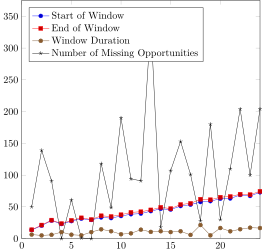

In [5]:
# Plot Differences in Opportunities
Axis([
    Plots.Linear(1:24, sdev_diff[1, :], legendentry="Start of Window")
    Plots.Linear(1:24, sdev_diff[2, :], legendentry="End of Window")
    Plots.Linear(1:24, sdev_diff[3, :], legendentry="Window Duration")
    Plots.Linear(1:24, missing_opportunities, legendentry="Number of Missing Opportunities")
], width="10cm", height="10cm", legendPos="north west", xmin=0, xmax=24, ymin=0)

In [6]:
# Graph planning
@time path, reward, image_list = sp_graph_policy(collects, Function[constraint_agility_single_axis], horizon=0.0, allow_repeats=false)
graph_path, graph_reward, graph_image_list = path, reward, image_list

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

graph_feasible = sp_check_feasibility(graph_path, Function[constraint_agility_single_axis])
println("GRAPH Constraint Check: $(graph_feasible ? "PASS" : "FAIL")")

34353.986465 seconds (4.17 G allocations: 226.312 GiB, 97.13% gc time)
Total planning reward: 1007.0
Number of images collected: 1007/1200, 83.91666666666666
Number of feasible images collected: 1007/1062, 94.8210922787194
GRAPH Constraint Check: PASS


In [ ]:
# MILP planning
@time path, reward, image_list = sp_milp_policy(collects, Function[constraint_agility_single_axis], horizon=0.0, allow_repeats=false)
milp_path, milp_reward, milp_image_list = path, reward, image_list

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

milp_feasible = sp_check_feasibility(milp_path, Function[constraint_agility_single_axis])
println("MILP Constraint Check: $(milp_feasible ? "PASS" : "FAIL")")

In [8]:
# MDP Planning

# Pre-compute collect probability
@time cp = compute_collect_probability(collects, perturbed_opportunities[1:10]);

Academic license - for non-commercial use only
Optimize a model with 3433365 rows, 37247 columns and 6901853 nonzeros
Variable types: 0 continuous, 37247 integer (37247 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Variable types: 0 continuous, 37247 integer (37247 binary)

Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.00s

Barrier performed 0 iterations in 178.75 seconds
Barrier solve interrupted - model solved by another algorithm

Concurrent spin time: 170.00s (can be avoided by choosing Method=3)

Solved with dual simplex

Root relaxation: objective 1.062000e+03, 1415 iterations, 175.93 seconds
Total elapsed time = 193.00s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/

Internal error: encountered unexpected error in runtime:
InterruptException()
jl_mutex_unlock at /Users/osx/buildbot/slave/package_osx64/build/src/./locks.h:138 [inlined]
jl_typeinf_end at /Users/osx/buildbot/slave/package_osx64/build/src/gf.c:2610
typeinf_ext at ./compiler/typeinfer.jl:577
typeinf_ext at ./compiler/typeinfer.jl:613
jfptr_typeinf_ext_1.clone_1 at /Applications/Julia-1.1.app/Contents/Resources/julia/lib/julia/sys.dylib (unknown line)
jl_apply_generic at /Users/osx/buildbot/slave/package_osx64/build/src/gf.c:2219 [inlined]
jl_apply at /Users/osx/buildbot/slave/package_osx64/build/src/./julia.h:1571 [inlined]
jl_type_infer at /Users/osx/buildbot/slave/package_osx64/build/src/gf.c:277
jl_compile_method_internal at /Users/osx/buildbot/slave/package_osx64/build/src/gf.c:1819
jl_fptr_trampoline at /Users/osx/buildbot/slave/package_osx64/build/src/gf.c:1863
do_call at /Users/osx/buildbot/slave/package_osx64/build/src/interpreter.c:323
eval_stmt_value at /Users/osx/buildbot/sla

InterruptException: InterruptException:

In [20]:
# MDP Planning

# Pre-compute collect probability
@time col_prob = compute_collect_probability(collects, perturbed_opportunities[1:10]);

120.430093 seconds (1.05 M allocations: 48.284 MiB, 0.02% gc time)


In [21]:
# Test MDP Forward Search Solution
@time path, reward, image_list = mdp_forward_search(collects, Function[constraint_agility_single_axis], 
                                                    images, col_prob,
                                                    horizon=4000, gamma=0.7, search_depth=1);

mdp_path, mdp_reward, mdp_image_list = path, reward, image_list

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

mdp_feasible = sp_check_feasibility(path, Function[constraint_agility_single_axis])
println("MDP Constraint Check: $(mdp_feasible ? "PASS" : "FAIL")")

Number of all images: 1200, Collected: 801, Missed: 399
412.861030 seconds (2.87 G allocations: 105.077 GiB, 10.67% gc time)
Total planning reward: 801.0
Number of images collected: 801/1200, 66.75
Number of feasible images collected: 801/1062, 75.42372881355932
MDP Constraint Check: PASS


In [14]:
# realized_reward, feasible_collects, infeasible_collects = sp_evaluate_plan(mdp_path, perturbed_opportunities[1])
# realized_reward, feasible_collects, infeasible_collects = sp_evaluate_plan(mdp_path, true_opportunities)
realized_rewards, mean_reward, sdev_reward = sp_compute_collect(graph_path, perturbed_opportunities[11:end])

([988.0, 968.0, 985.0, 978.0, 981.0, 268.0, 972.0, 276.0, 596.0, 1002.0  …  972.0, 208.0, 438.0, 766.0, 387.0, 259.0, 279.0, 598.0, 988.0, 959.0], 670.27, 320.959478703616)

In [15]:
realized_rewards, mean_reward, sdev_reward = sp_compute_collect(milp_path, perturbed_opportunities[11:end])

UndefVarError: UndefVarError: milp_path not defined

In [22]:
realized_rewards, mean_reward, sdev_reward = sp_compute_collect(mdp_path, perturbed_opportunities[11:end])

([792.0, 784.0, 789.0, 792.0, 791.0, 340.0, 783.0, 345.0, 617.0, 799.0  …  785.0, 265.0, 514.0, 642.0, 499.0, 323.0, 344.0, 616.0, 796.0, 778.0], 603.82, 207.45316521464733)